## 🌊 Regresión lineal

#### Librerías y ajustes iniciales

In [1]:
from sklearn.linear_model import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from ml_flow_utils import MLFlow
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

In [2]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

In [3]:
# FIJAMOS SEMILLA ALEATORIA
RANDOM_STATE = 777

### 📈 Análisis de los datos

#### Análisis variable respuesta (AlturaOlas)

Cargamos los datos

In [4]:
df = pd.read_parquet("../clean/df_definitivo.parquet")
y_name = "AlturaOlas"
X = df.drop(columns=y_name)
y = df[y_name]

Text(0.5, 0, 'metros')

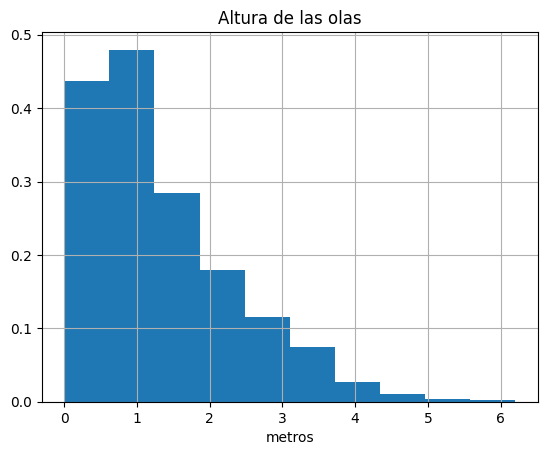

In [5]:
y.hist(density=True)
plt.title("Altura de las olas")
plt.xlabel("metros")

Analizando el diagrama de densidad, podemos apreciar que tenemos una asimetría a la derecha.

Algo obvio, pues se trata de una variable no negativa. Con esto en mente debemos tener cuidado con los outliers, que son los principales enemigos de la regresión lineal.

Viendo el histograma, podríamos decir que las olas de más de 3 metros son outliers o valores extremos, pues son infrecuentes y su valor está muy por encima de los valores habituales.

Para ver mejor esta última parte de los outliers, realizaremos un boxplot.


Text(0.5, 0, 'metros')

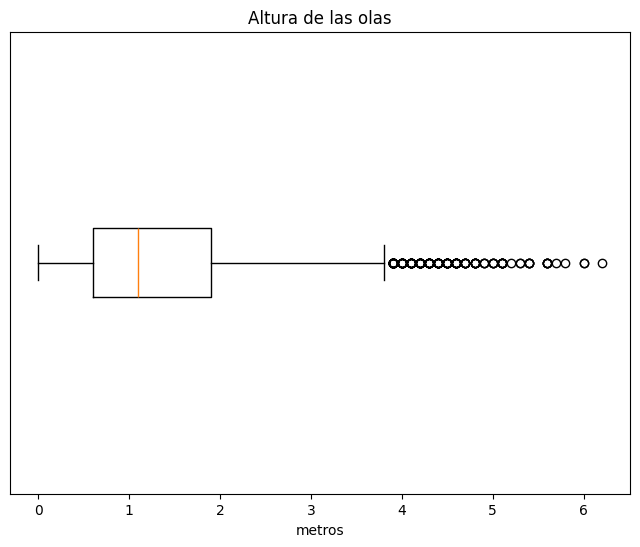

In [6]:
plt.figure(figsize=(8, 6))
plt.boxplot(y, vert=False)
plt.title("Altura de las olas")
plt.yticks([])
plt.xlabel("metros")

En este caso, igual que hemos apreciado en el anterior gráfico, ha marcado a olas mayores de 3,5 metros como outliers.

Esto lo tenemos que tener en cuenta para nuestro estudio, pues puede ser relevante intentar aplicar los métodos de transformación para hacer la curva de la distribución más simétrica.

In [7]:
print("Altura media:", y.mean().round(3), "Desviación:", y.std().round(3))

Altura media: 1.36 Desviación: 0.969


#### Análisis columnas explicativas

In [8]:
X.columns

Index(['anio', 'mes', 'dia', 'moonphase', 'hora', 'temp', 'dewPt',
       'heat_index', 'rh', 'pressure', 'vis', 'wc', 'wspd', 'feels_like',
       'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE',
       'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE', 'wdir_SSE',
       'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW', 'wdir_WSW',
       'Vviento', 'PeriodoOlas', 'Temperatura', 'Lluvia', 'Nubosidad'],
      dtype='object')

In [9]:
#X.drop(columns=['anio', 'mes', 'dia', 'hora'])

Nos centraremos en la correlación entre variables explicativas, quitando variables que presenten una correlación alta(> 0,75 o bien < -0,75)

La multicolinealidad en la regresión lineal causa problemas como coeficientes poco fiables, dificulta la interpretación de los efectos de las variables y reduce la precisión predictiva.

Una primera observación - tenemos columnas que nos dicen información muy parecida:

1. Temperatura (de la boya en grados celsius) y temp (de la playa en grados Farenheit)
2. wspd (velocidad de viento en la playa) y Vviento (velocidad de viento en la boya), ambas en km/h

In [10]:
X[['Temperatura', 'temp']].corr(method="pearson")

,Temperatura,temp
Temperatura,1.000000,0.958807
temp,0.958807,1.000000


In [11]:
X[['Temperatura', 'temp']].corr(method="spearman")

,Temperatura,temp
Temperatura,1.00000,0.96164
temp,0.96164,1.00000


In [12]:
X[['wspd', 'Vviento']].corr(method="spearman")

,wspd,Vviento
wspd,1.000000,0.807545
Vviento,0.807545,1.000000


In [13]:
X[['wspd', 'Vviento']].corr(method="pearson")

,wspd,Vviento
wspd,1.000000,0.823775
Vviento,0.823775,1.000000


In [14]:
df[['wspd', 'Vviento', 'Temperatura', 'temp', 'AlturaOlas']].corr()['AlturaOlas']

wspd           0.618414
Vviento        0.771499
Temperatura   -0.179669
temp          -0.185574
AlturaOlas     1.000000
Name: AlturaOlas, dtype: float64

Nos quedamos con la columnas temp y Vviento, porque son las que mayor correlación lineal (en valor absoluto) tienen con la variable respuesta

In [15]:
X = X.drop(columns=["Temperatura", 'wspd'])

Pasamos a realizar el análisis general de las correlaciones, excluyendo las variables dummy (dirección de viento)

In [16]:
not_dummy_cols = [c for c in X.columns if not c.startswith('wdir_')]
print(not_dummy_cols)

['anio', 'mes', 'dia', 'moonphase', 'hora', 'temp', 'dewPt', 'heat_index', 'rh', 'pressure', 'vis', 'wc', 'feels_like', 'uv_index', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']


In [17]:
# fuente: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

def plot_corrs(df):
    corrSpe = df.corr(method="spearman")
    corrPea = df.corr(method="pearson")
    mask = np.triu(np.ones_like(corrSpe, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(1, 2, figsize=(14, 8))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corrSpe, ax=ax[0], mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax[0].set_title("Spearman")
    sns.heatmap(corrPea, ax=ax[1], mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax[1].set_title("Pearson")

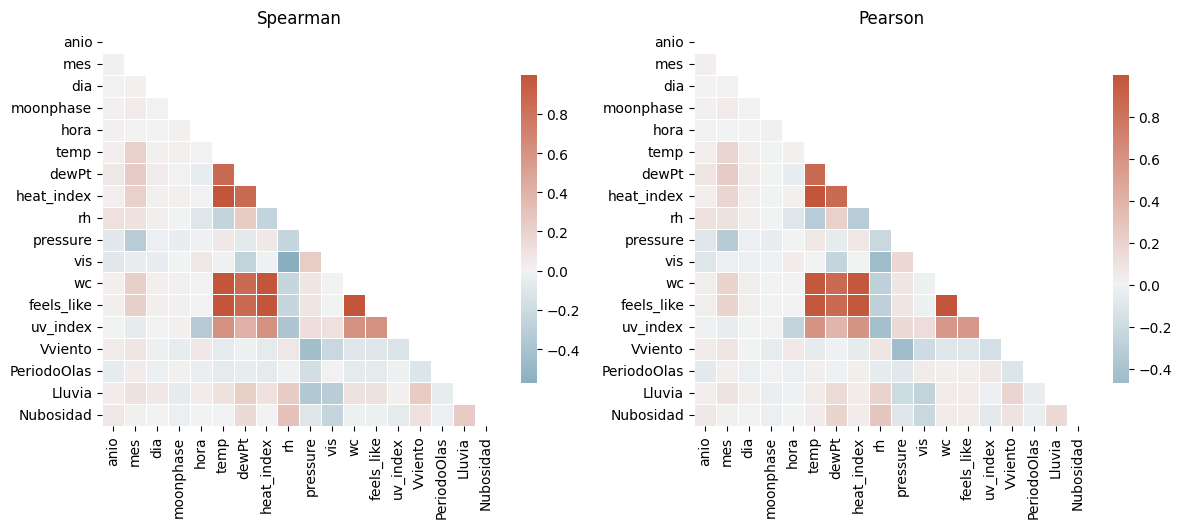

In [18]:
plot_corrs(X[not_dummy_cols])

Juntando nuestro conocimiento sobre las variables y el mapa de calor

1. Las columnas wc y feels_like respresenta la temperatura percibida por el humano, que es calculada a partir de otras columnas.

2. heat_index (Temperatura de bochorno) también se calcula a partir de humedad y temperatura del aire.

3. dewPt, punto de rocío, temperatura a la cual se debe enfriar el aire para que el vapor de agua se condense en rocío o escarcha, podemos ver que está muy relacionada con la temperatura del aire.

Para evitar multicolinealidad, las vamos a eliminar.

In [19]:
X = X.drop(columns=['wc', 'feels_like', 'heat_index', 'dewPt'])
not_dummy_cols.remove('wc')
not_dummy_cols.remove('feels_like')
not_dummy_cols.remove('heat_index')
not_dummy_cols.remove('dewPt')

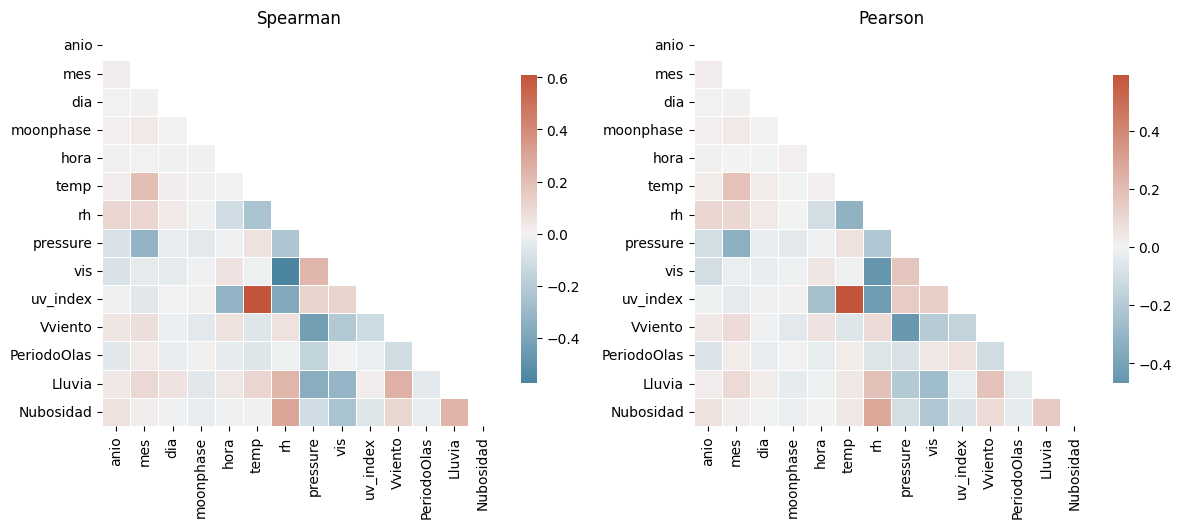

In [20]:
plot_corrs(X[not_dummy_cols])

A pesar de que aparece una destacable correlación entre uv_index y temp, si nos fijamos en el valor, no es muy alto, por lo que la podemos dejar

In [21]:
X[['temp', 'uv_index']].corr()

,temp,uv_index
temp,1.000000,0.592247
uv_index,0.592247,1.000000


Vemos las correlaciones con la variable respuesta (última fila)

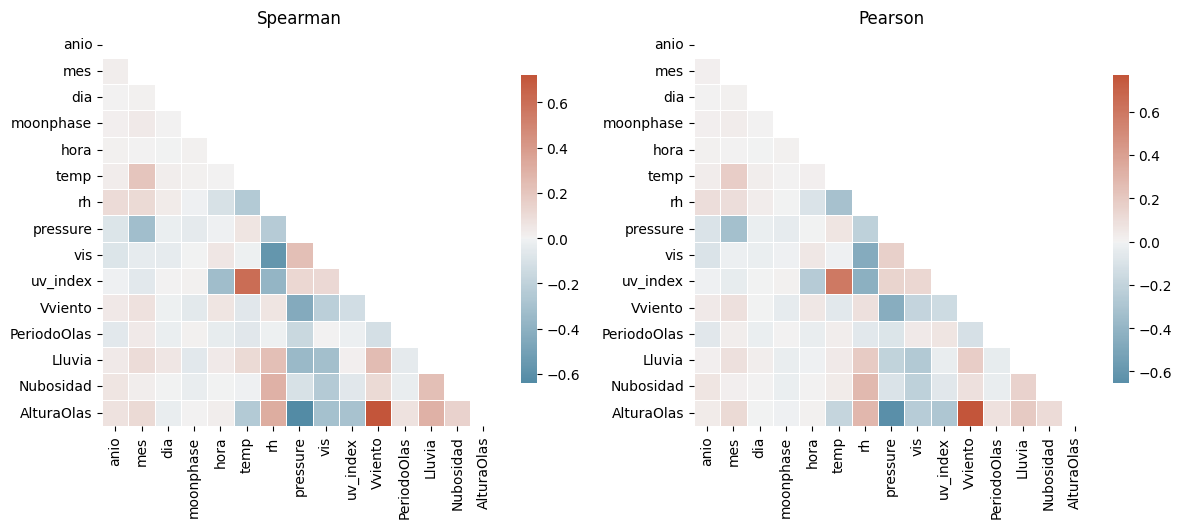

In [22]:
plot_corrs(pd.concat([X[not_dummy_cols], y], axis=1))

Parece ser que nuestras predicciones se van a basar alrededor del viento y la presión atmosférica.

Pasamos a analizar la variable objetivo con las direcciones del viento (última fila)

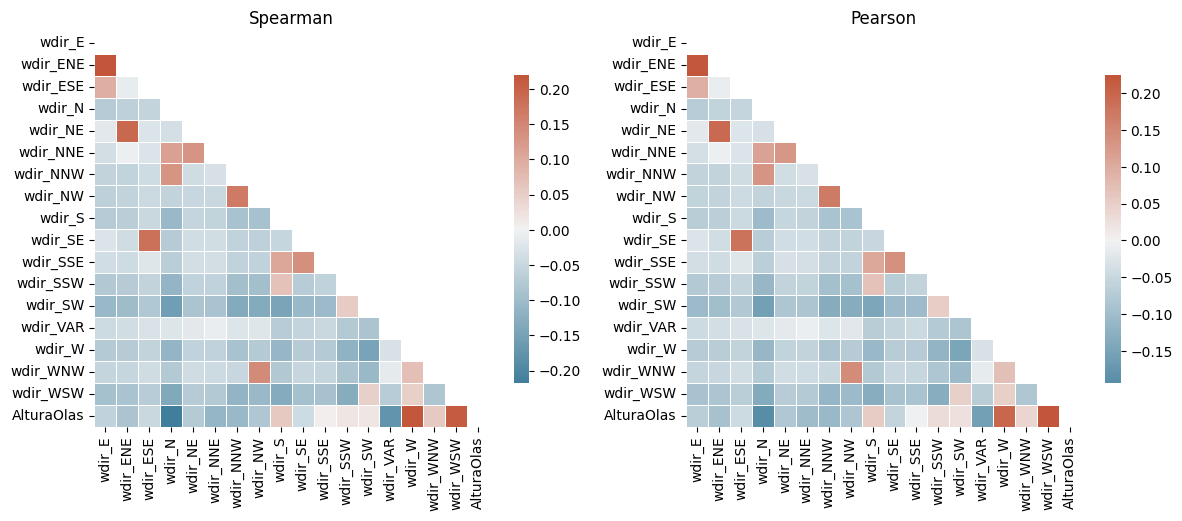

In [23]:
plot_corrs(pd.concat([X[[c for c in X.columns if c.startswith('wdir_')]], y], axis=1))

Vemos que la escala de correlaciones no sube de 0.3 y no baja de -0.2.

Esto quiere decir que hay muy poca correlación entre las variables dummy con la respuesta.

### 🔨 Construcción de modelos

Habrá que mover a otro dataframe, modelos planteados:
1. Regresión lineal sin regularizar
2. Regresión Ridge
3. Regresión Lasso
4. Regresión Elastic

Lo mismo pero con las variables escalonadas(+4)

Transformar variable respuesta para que sea simétrica? (boxcox) (+4)

#### Separación en train y test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

#### Distribuciones de a variable respuesta en train y test

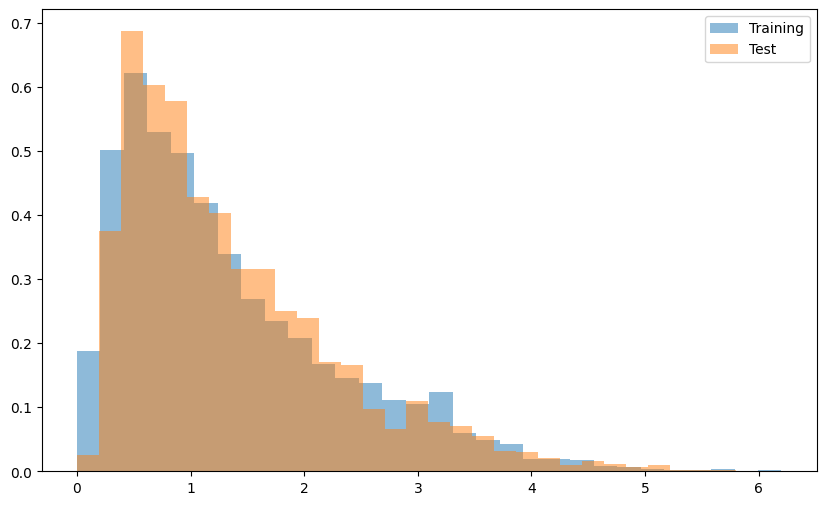

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(y_train, bins=30, alpha=0.5, label='Training', density=True)
ax.hist(y_test, bins=30, alpha=0.5, label='Test', density=True)
plt.legend()

Analizando las funciones de densidad de los dos conjuntos vemos que se parecen bastante, a excepción de las olas de altura menor a 0.5, las cuáles parecen estar en mayor proporción en training que en el conjunto test.

In [26]:
params = {
    "random_state": [RANDOM_STATE],
    "alpha": [i/100 for i in range(1, 101, 2)],
    "max_iter": [100, 500, 1000, 2000, 5000],
}

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
rdg = Ridge()
rdgSearch = GridSearchCV(rdg, params, cv=5)
rdgSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13,
                                   0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27,
                                   0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41,
                                   0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55,
                                   0.57, 0.59, ...],
                         'max_iter': [100, 500, 1000, 2000, 5000],
                         'random_state': [777]})

In [28]:
las = Lasso()
lasSearch = GridSearchCV(las, params, cv=5)
lasSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13,
                                   0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27,
                                   0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41,
                                   0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55,
                                   0.57, 0.59, ...],
                         'max_iter': [100, 500, 1000, 2000, 5000],
                         'random_state': [777]})

In [29]:
el = ElasticNet() # reemplazar alpha por l1_ratio...
elSearch = GridSearchCV(el, params, cv=5)
elSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13,
                                   0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27,
                                   0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41,
                                   0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55,
                                   0.57, 0.59, ...],
                         'max_iter': [100, 500, 1000, 2000, 5000],
                         'random_state': [777]})